# [Dev notebook]
## How does STGL work with TICC data?

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy import linalg
from sklearn.metrics import v_measure_score
from sklearn.model_selection import StratifiedShuffleSplit

from regain.utils import structure_error, error_norm_time, normalize_matrix

In [2]:
from imp import reload
from regain.covariance import kernel_time_graphical_lasso_, kernel_latent_time_graphical_lasso_
from regain.datasets import kernels; reload(kernels)

n_dim = 10
w_size = 1
n_samples = 50
clusters=(0,0,0,0,1,1,1,1,0,0,0,0)

In [3]:
data = kernels.make_ticc_dataset_v3(
    clusters=clusters,
    w_size=w_size, n_dim=n_dim, n_samples=n_samples)
X, y = data.X, data.y

In [4]:
# # print the inv matrix
# res = sns.clustermap(data.inv, row_cluster=False, col_cluster=False)
# ax = res.ax_heatmap
# for i in range(n_samples * len(clusters)):
#     ax.axvline((i + 1) * n_dim)
#     ax.axhline((i + 1) * n_dim)

In [5]:
cov = []
for c in np.unique(y):
    idx = y == c
    cov.append(empirical_covariance(X[idx]))
cov = np.asarray(cov)

kernel = np.zeros((cov.shape[0], cov.shape[0]))
for i in range(cov.shape[0]):
    for j in range(i + 1, cov.shape[0]):
        kernel[i, j] = kernel[j, i] = (np.linalg.norm((cov[i]) - (cov[j])))

mm = np.sum(np.abs(kernel), axis=1)
kernel += np.eye(cov.shape[0]) * mm

normalize_matrix(kernel)

STGL

In [6]:
reload(kernel_time_graphical_lasso_)
reload(kernel_latent_time_graphical_lasso_)

<module 'regain.covariance.kernel_latent_time_graphical_lasso_' from '/home/federicot/src/fdtomasi/regain/regain/covariance/kernel_latent_time_graphical_lasso_.py'>

In [7]:
from regain.norm import l1_od_norm
mdl = kernel_time_graphical_lasso_.SimilarityTimeGraphicalLasso(
    psi='l1', max_iter=500, alpha=0.1, beta=1, kernel=kernel)

SLTGL

In [8]:
mdl = kernel_latent_time_graphical_lasso_.SimilarityLatentTimeGraphicalLasso(
    alpha=1, tau=0.9, beta=2, eta=0.75)

In [9]:
# from sklearn.gaussian_process import kernels as skkernels
# rbf = kernels.RBF

# mdl = kernel_time_graphical_lasso_.KernelTimeGraphicalLasso(psi='l1', max_iter=500, alpha=0.1, beta=1, kernel=rbf).fit(X, y)

# from regain.norm import l1_od_norm
# mdl.similarity_matrix = kernel_time_graphical_lasso_.precision_similarity(mdl.precision_, l1_od_norm)

In [10]:
from time import time

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import clone
from regain.covariance import time_graphical_lasso_, latent_time_graphical_lasso_

In [11]:
stgl = kernel_time_graphical_lasso_.SimilarityTimeGraphicalLasso(alpha=1, beta=2)
sltgl = kernel_latent_time_graphical_lasso_.SimilarityLatentTimeGraphicalLasso(alpha=0.75, tau=0.9, beta=2, eta=0.75)
clust = AgglomerativeClustering()

In [12]:
from ticc import TICC_solver; 
from imp import reload; reload(TICC_solver)

<module 'ticc.TICC_solver' from '/home/federicot/src/fdtomasi/TICC/ticc/TICC_solver.py'>

In [13]:
# ticc = TICC_solver.TICC(number_of_clusters=np.unique(clusters).size, window_size=1)
# cluster_assignment, cluster_MRFs = ticc.fit(X)

# from sklearn.metrics import v_measure_score
# v_measure_score(data.id_cluster, cluster_assignment)

# pipe_stgl = Pipeline([('stgl', clone(stgl)), ('clust', clone(clust))])
# labels_pred = pipe_stgl.set_params(clust__n_clusters=np.unique(clusters).size).fit_predict(X, y)

# v_measure_score(data.id_cluster, np.repeat(labels_pred, n_samples))

In [14]:
n_clusts = np.random.randint(10) + 2
clusters = np.random.choice(list(range(n_clusts)), size=15)
data = kernels.make_ticc_dataset_v3(
    clusters=clusters,
    w_size=w_size, n_dim=n_dim, n_samples=20)
X, y = data.X, data.y

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
from skopt import searchcv; from imp import reload; reload(searchcv)
from skopt.space import Real, Categorical, Integer
from sklearn.datasets import load_iris
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split

domain = {'alpha': Real(1e-1, 1e0, prior='log-uniform'),
          'tau': Real(1e-1, 1e+1, prior='log-uniform'),
          'beta': Integer(1, 60)}
    
cv = StratifiedShuffleSplit(10, test_size=0.2)
    
bscv = searchcv.BayesSearchCV(sltgl, domain, n_iter=32, cv=cv)

bscv.fit(X, y)

/home/federicot/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/federicot/src/fdtomasi/regain/regain/covariance/kernel_latent_time_graphical_lasso_.py:286: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")
/home/federicot/src/fdtomasi/regain/regain/covariance/kernel_latent_time_graphical_lasso_.py:286: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")
/home/federicot/src/fdtomasi/regain/regain/covariance/kernel_latent_time_graphical_lasso_.py:286: UserWarning: Objective did not converge.
  warnings.warn("Obje

BayesSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=None),
              error_score='raise',
              estimator=SimilarityLatentTimeGraphicalLasso(alpha=0.75,
                                                           assume_centered=False,
                                                           beta=2,
                                                           compute_objective=True,
                                                           eps=1e-06, eta=0.75,
                                                           init='empirical',
                                                           ker_phi_param=1,
                                                           ker_psi_param=1,
                                                           kernel_phi=None,
                                                           kernel_psi=None,
                                                           max_iter=100,
           

In [15]:
# partitions = np.arange(0.1, 1, 0.1)
partitions = [5, 10, 50, 100, 200, 500, 1000]
n_splits = 10

n_dim = 10
w_size = 2
n_samples = 1000

vs, ne, se = {}, {}, {}
datas = {}
for i in partitions:
    # v_scores, norm_errors, structure_errors = [], [], []
    
    # for train, _, in StratifiedShuffleSplit(n_splits=n_splits, train_size=float(i)).split(X, y):
    for j in range(n_splits):
        n_clusts = np.random.randint(10) + 2
        clusters = np.random.choice(list(range(n_clusts)), size=15)
        data = kernels.make_ticc_dataset_v3(
            clusters=clusters,
            w_size=w_size, n_dim=n_dim, n_samples=i)
        X, y = data.X, data.y
        
        n_times = np.unique(y).size
        thetas_true = np.array([data.precs[l] for l in y])
        thetas_true_sparse = np.array([data.sparse_precs[l] for l in y])
        labels_true = data.id_cluster #[::(len(clusters) * i // n_times)]
        
        thetas_true_sparse_rep = np.array([thetas_true_sparse[l] for l in y])
        thetas_true_rep = np.array([thetas_true[l] for l in y])
        
        datas.setdefault(i, {}).setdefault('data', []).append(data)
        datas.setdefault(i, {}).setdefault('thetas_true', []).append(thetas_true)
        datas.setdefault(i, {}).setdefault('thetas_true_sparse', []).append(thetas_true_sparse)
        datas.setdefault(i, {}).setdefault('thetas_true_sparse_rep', []).append(thetas_true_sparse_rep)
        datas.setdefault(i, {}).setdefault('thetas_true_rep', []).append(thetas_true_rep)
        datas.setdefault(i, {}).setdefault('labels_true', []).append(labels_true)
        
        # STGL
        pipe_stgl = Pipeline([('stgl', clone(stgl)), ('clust', clone(clust))])
        pipe_stgl.set_params(clust__n_clusters=np.unique(clusters).size)
        tic = time()
        labels_pred = pipe_stgl.fit_predict(X, y)
        tac = time() - tic
        labels_pred = np.repeat(labels_pred, i)
        
        mdl = pipe_stgl['stgl']
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        vs.setdefault(('stgl', i), {}).setdefault('model', []).append(pipe_stgl)
        vs.setdefault(('stgl', i), {}).setdefault('v_measure', []).append(
            v_measure_score(labels_true, labels_pred))
        vs.setdefault(('stgl', i), {}).setdefault('structure_error', []).append(
            structure_error(thetas_true_sparse, obs_precs_sparse, no_diagonal=True))
        vs.setdefault(('stgl', i), {}).setdefault('error_norm', []).append(
            error_norm_time(thetas_true_rep, obs_precs))
        vs.setdefault(('stgl', i), {}).setdefault('error_norm_sparse', []).append(
            error_norm_time(thetas_true_rep_sparse, obs_precs_sparse))
        vs.setdefault(('stgl', i), {}).setdefault('time', []).append(tac)
        
        # SLTGL
        pipe_sltgl = Pipeline([('sltgl', clone(sltgl)), ('clust', clone(clust))])
        pipe_sltgl.set_params(clust__n_clusters=np.unique(clusters).size)
        tic = time()
        labels_pred = pipe_sltgl.fit_predict(X, y)
        tac = time() - tic
        labels_pred = np.repeat(labels_pred, i)
        
        mdl = pipe_sltgl['sltgl']
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        vs.setdefault(('sltgl', i), {}).setdefault('model', []).append(pipe_sltgl)
        vs.setdefault(('sltgl', i), {}).setdefault('v_measure', []).append(
            v_measure_score(labels_true, labels_pred))
        vs.setdefault(('sltgl', i), {}).setdefault('structure_error', []).append(
            structure_error(thetas_true_sparse, obs_precs_sparse, no_diagonal=True))
        vs.setdefault(('sltgl', i), {}).setdefault('error_norm', []).append(
            error_norm_time(thetas_true_rep, obs_precs))
        vs.setdefault(('sltgl', i), {}).setdefault('error_norm_sparse', []).append(
            error_norm_time(thetas_true_rep_sparse, obs_precs_sparse))
        vs.setdefault(('sltgl', i), {}).setdefault('time', []).append(tac)
        
        # TGL + similarity
        tgl = time_graphical_lasso_.TimeGraphicalLasso(alpha=1, beta=2)
        tic = time()
        tgl.fit(X, y)        
        tac = time() - tic
        psi = kernel_time_graphical_lasso_.check_norm_prox(tgl.psi)[0]
        tgl_prec_sims = kernel_time_graphical_lasso_.precision_similarity(tgl.get_observed_precision(), psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(tgl_prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        mdl = tgl
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        vs.setdefault(('tgl', i), {}).setdefault('model', []).append(mdl)
        vs.setdefault(('tgl', i), {}).setdefault('v_measure', []).append(
            v_measure_score(labels_true, labels_pred))
        vs.setdefault(('tgl', i), {}).setdefault('structure_error', []).append(
            structure_error(thetas_true_sparse, obs_precs_sparse, no_diagonal=True))
        vs.setdefault(('tgl', i), {}).setdefault('error_norm', []).append(
            error_norm_time(thetas_true_rep, obs_precs))
        vs.setdefault(('tgl', i), {}).setdefault('error_norm_sparse', []).append(
            error_norm_time(thetas_true_rep_sparse, obs_precs_sparse))
        vs.setdefault(('tgl', i), {}).setdefault('time', []).append(tac)
        
        # LTGL + similarity
        ltgl = latent_time_graphical_lasso_.LatentTimeGraphicalLasso(alpha=0.5, beta=2, tau=0.9, eta=0.25)
        tic = time()
        ltgl.fit(X, y)
        tac = time() - tic
        psi = kernel_latent_time_graphical_lasso_.check_norm_prox(ltgl.psi)[0]
        ltgl_prec_sims = kernel_time_graphical_lasso_.precision_similarity(ltgl.get_observed_precision(), psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(ltgl_prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        mdl = ltgl
        
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        vs.setdefault(('ltgl', i), {}).setdefault('model', []).append(mdl)
        vs.setdefault(('ltgl', i), {}).setdefault('v_measure', []).append(
            v_measure_score(labels_true, labels_pred))
        vs.setdefault(('ltgl', i), {}).setdefault('structure_error', []).append(
            structure_error(thetas_true_sparse, obs_precs_sparse, no_diagonal=True))
        vs.setdefault(('ltgl', i), {}).setdefault('error_norm', []).append(
            error_norm_time(thetas_true_rep, obs_precs))
        vs.setdefault(('ltgl', i), {}).setdefault('error_norm_sparse', []).append(
            error_norm_time(thetas_true_rep_sparse, obs_precs_sparse))
        vs.setdefault(('ltgl', i), {}).setdefault('time', []).append(tac)
        
        ticc = TICC_solver.TICC(number_of_clusters=np.unique(clusters).size, window_size=1)
        tic = time()
        try:
            cluster_assignment, cluster_MRFs = ticc.fit(X)
        except:
            cluster_assignment = np.zeros_like(labels_true)
            cluster_MRFs = {0: np.eye(X.shape[1])}
            
        tac = time() - tic
        
        obs_precs = np.array([cluster_MRFs[l] for l in cluster_assignment])
        obs_precs_sparse = obs_precs
        
        vs.setdefault(('ticc', i), {}).setdefault('model', []).append(ticc)
        vs.setdefault(('ticc', i), {}).setdefault('v_measure', []).append(
            v_measure_score(labels_true, cluster_assignment))
        vs.setdefault(('ticc', i), {}).setdefault('structure_error', []).append(
            structure_error(thetas_true_sparse_rep, obs_precs_sparse, no_diagonal=True))
        vs.setdefault(('ticc', i), {}).setdefault('error_norm', []).append(
            error_norm_time(thetas_true_rep, obs_precs))
        vs.setdefault(('ticc', i), {}).setdefault('error_norm_sparse', []).append(
            error_norm_time(thetas_true_rep_sparse, obs_precs_sparse))
        vs.setdefault(('ticc', i), {}).setdefault('time', []).append(tac)
    
#     vs.append(v_scores)
#     ne.append(norm_errors)
#     se.append(structure_errors)

/home/federicot/src/fdtomasi/regain/regain/covariance/kernel_time_graphical_lasso_.py:231: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")
/home/federicot/src/fdtomasi/regain/regain/covariance/kernel_latent_time_graphical_lasso_.py:286: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")
/home/federicot/src/fdtomasi/regain/regain/covariance/time_graphical_lasso_.py:267: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")
/home/federicot/src/fdtomasi/TICC/ticc/TICC_solver.py:417: RuntimeWarning: Degrees of freedom <= 0 for slice
  S = np.cov(np.transpose(D_train))
/home/federicot/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/federicot/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply

/home/federicot/src/fdtomasi/TICC/ticc/TICC_solver.py:417: RuntimeWarning: Degrees of freedom <= 0 for slice
  S = np.cov(np.transpose(D_train))
/home/federicot/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/federicot/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/federicot/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/federicot/src/fdtomasi/TICC/ticc/TICC_solver.py:417: RuntimeWarning: Degrees of freedom <= 0 for slice
  S = np.cov(np.transpose(D_train))
/home/federicot/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.tr

In [ ]:
from regain import utils
utils.save_pickle(vs, 'results_synthetic_2207.pkl')

In [16]:
neww = {}
for k, v in vs.items():
    new = {}
    for kk, vv in v.items():
        new.update({(kk, i): vvv for i, vvv in enumerate(vv)})
    neww[k] = new

In [17]:
res_df = pd.DataFrame(neww)

In [18]:
res_df.index.name = ('measure', 'iter')

In [19]:
res_df.unstack(level=0).head()

stgl                                                     \
          5                                                       
  error_norm                                              model   
0    1.33803  (SimilarityTimeGraphicalLasso(alpha=1, assume_...   
1     1.3547  (SimilarityTimeGraphicalLasso(alpha=1, assume_...   
2    1.31497  (SimilarityTimeGraphicalLasso(alpha=1, assume_...   
3    1.46017  (SimilarityTimeGraphicalLasso(alpha=1, assume_...   
4     1.4062  (SimilarityTimeGraphicalLasso(alpha=1, assume_...   

                                                                         \
                                                                          
                                     structure_error     time v_measure   
0  {'tp': 2580, 'tn': 970, 'fp': 2480, 'fn': 720,...  7.60329  0.453556   
1  {'tp': 1800, 'tn': 2010, 'fp': 1440, 'fn': 150...  6.22492  0.558454   
2  {'tp': 1860, 'tn': 1810, 'fp': 1640, 'fn': 144...  5.81748  0.593005   
3  {'tp': 2340, 'tn': 1330, 'fp': 2120, 'fn': 960...  8.08392  0.524156   
4  {'tp': 1970, 'tn': 1710, 'fp': 1740, 'fn': 133...  7.65697  0.482633   

       sltgl                                                     \
          5                                                       
  error_norm                                              model   
0    1.49774  (SimilarityLatentTimeGraphicalLasso(alpha=0.75...   
1    1.58466  (SimilarityLatentTimeGraphicalLasso(alpha=0.75...   
2    1.45996  (SimilarityLatentTimeGraphicalLasso(alpha=0.75...   
3    1.39797  (SimilarityLatentTimeGraphicalLasso(alpha=0.75...   
4    1.45335  (SimilarityLatentTimeGraphicalLasso(alpha=0.75...   

                                                                         \
                                                                          
                                     structure_error     time v_measure   
0  {'tp': 830, 'tn': 2860, 'fp': 590, 'fn': 2470,...  4.20722         1   
1  {'tp': 600, 'tn': 3020, 'fp': 430, 'fn': 2700,...  4.20031  0.679371   
2  {'tp': 690, 'tn': 2990, 'fp': 460, 'fn': 2610,...  3.37181  0.605536   
3  {'tp': 860, 'tn': 2920, 'fp': 530, 'fn': 2440,...  3.36877  0.686243   
4  {'tp': 600, 'tn': 3030, 'fp': 420, 'fn': 2700,...   4.3679  0.684305   

         tgl                                                     \
          5                                                       
  error_norm                                              model   
0    1.18771  TimeGraphicalLasso(alpha=1, assume_centered=Fa...   
1    1.31998  TimeGraphicalLasso(alpha=1, assume_centered=Fa...   
2    1.15334  TimeGraphicalLasso(alpha=1, assume_centered=Fa...   
3    1.32511  TimeGraphicalLasso(alpha=1, assume_centered=Fa...   
4    1.30107  TimeGraphicalLasso(alpha=1, assume_centered=Fa...   

                                                                          \
                                                                           
                                     structure_error      time v_measure   
0  {'tp': 2100, 'tn': 1510, 'fp': 1940, 'fn': 120...  0.220058  0.307104   
1  {'tp': 1640, 'tn': 2000, 'fp': 1450, 'fn': 166...  0.214555  0.552415   
2  {'tp': 1720, 'tn': 1950, 'fp': 1500, 'fn': 158...  0.232754  0.523527   
3  {'tp': 1990, 'tn': 1740, 'fp': 1710, 'fn': 131...  0.239582  0.544248   
4  {'tp': 1840, 'tn': 1640, 'fp': 1810, 'fn': 146...  0.220672  0.502194   

        ltgl                                                     \
          5                                                       
  error_norm                                              model   
0    2.09974  LatentTimeGraphicalLasso(alpha=0.5, assume_cen...   
1    2.49254  LatentTimeGraphicalLasso(alpha=0.5, assume_cen...   
2       2.25  LatentTimeGraphicalLasso(alpha=0.5, assume_cen...   
3    1.92571  LatentTimeGraphicalLasso(alpha=0.5, assume_cen...   
4    2.02348  LatentTimeGraphicalLasso(alpha=0.5, assume_cen...   

                                                 

In [20]:
rr = res_df.T.reset_index()
rr = rr.rename(columns={'level_0': 'method', 'level_1': 'samples'})
rr.method = rr.method.str.upper()

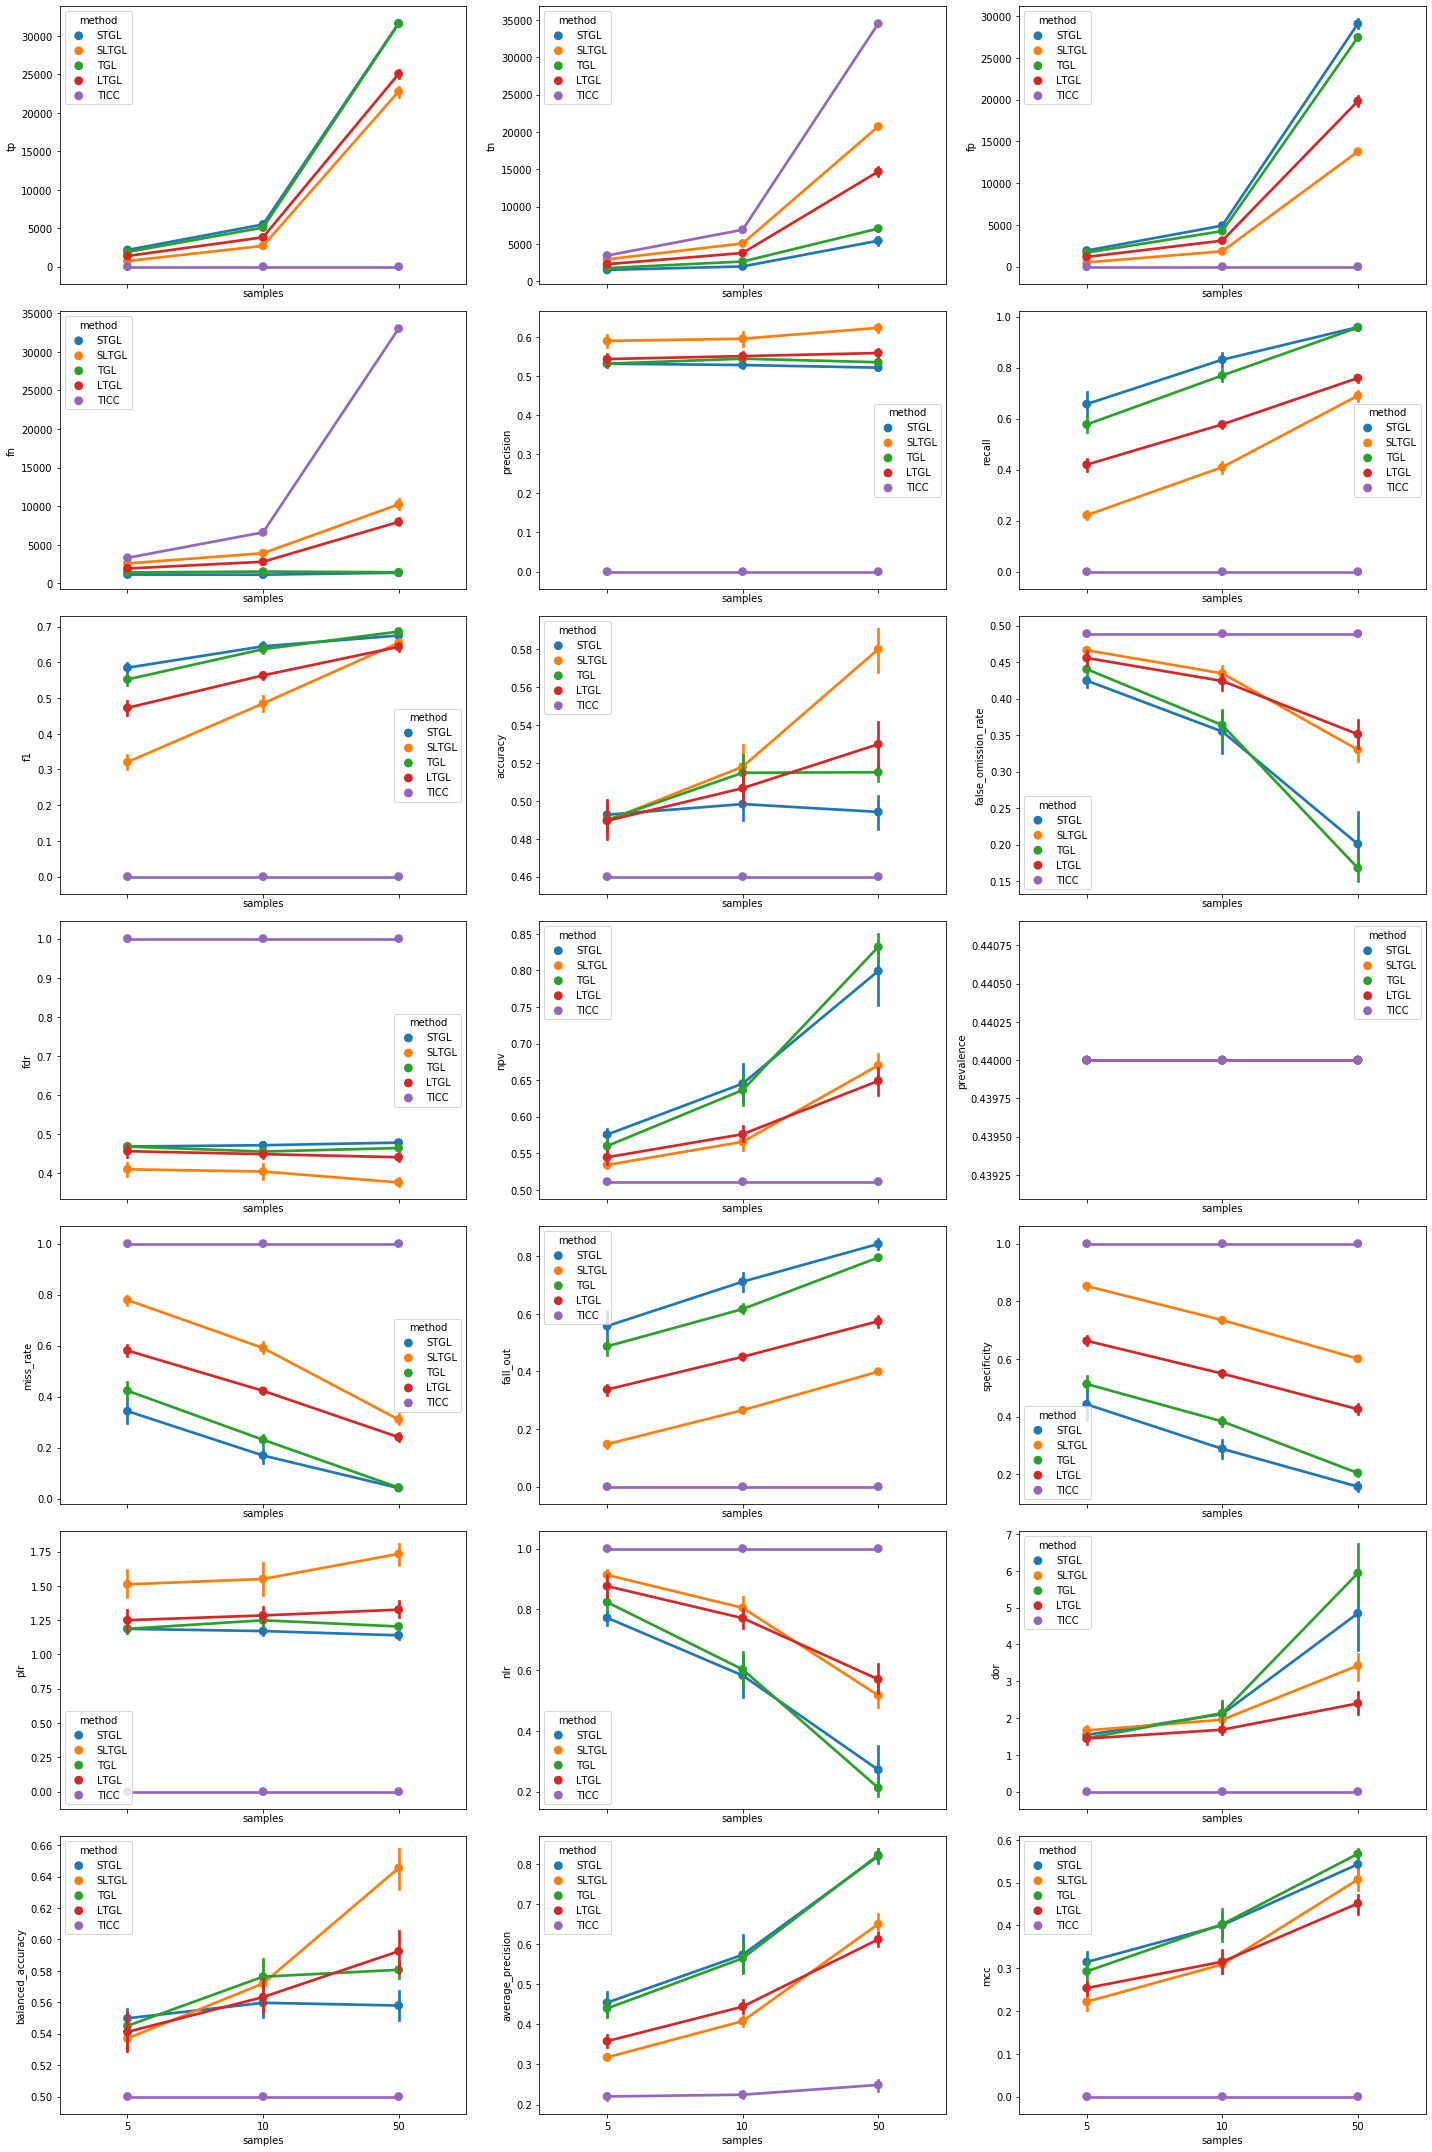

In [27]:
melt = pd.melt(rr, id_vars=['method', 'samples'], value_vars=['structure_error'])
for k in melt.value[0]:
    melt[k] = melt.value.apply(lambda x: x[k])

f, ax = plt.subplots(7,3, figsize=(20,30), sharex=True)
mm = np.array(list(melt.value[0].keys())).reshape(7,3)
for r in range(mm.shape[0]):
    for c in range(mm.shape[1]):
        ax[r,c] = sns.pointplot(x='samples', y=mm[r,c], data=melt, hue='method', ax=ax[r,c])

f.tight_layout()
f

In [28]:
f.savefig('structure_error1.png')

In [78]:
f, ax = plt.subplots(1,3, figsize=(15,5), sharex=True)
for i, val in enumerate(['time', 'error_norm', 'v_measure']):
    melt = pd.melt(rr, id_vars=['method', 'samples'], value_vars=[val], value_name=val)
    melt.head()

    ax[i] = sns.pointplot(x='samples', y=val, data=melt, hue='method', ax=ax[i])
    if val == 'time':
        ax[i].set_yscale('log')
f.tight_layout()

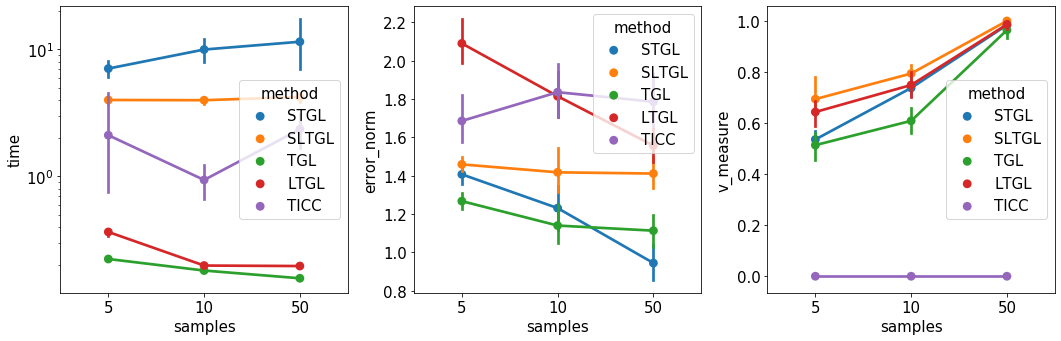

In [79]:
f

In [31]:
f.savefig('time_error_vscore1.png')

In [19]:
d = []
for i, index in enumerate(partitions):
    index = int(index)
    for col in range(n_splits):
        d.append((dict(sample=index, col=col, val=np.array(vs)[i,col], type='v_scores')))
        d.append(dict(sample=index, col=col, val=np.array(ne)[i,col], type='norm_errors'))
        d.append(dict(sample=index, col=col, val=np.array(se)[i,col]['balanced_accuracy'], type='structure_errors'))

A = pd.DataFrame(d)

ax = sns.pointplot(x='sample', y='val', data=A, hue='type')

plt.pyplot.gcf().savefig("error.png")

IndexError: too many indices for array

In [ ]:
# thetas_true = np.array([np.array(data.precs)[x].mean(axis=0) for x in 
#                         [np.arange(i*(len(clusters) * (n_samples) // n_times),
#                                    (i+1)*(len(clusters) * (n_samples) // n_times))  for i in range(len(clusters) * (n_samples) // n_times - 1)]])
# thetas_true_sparse= np.array([np.array(data.sparse_precs)[x].mean(axis=0) for x in [np.arange(i*(len(clusters) * (n_samples) // n_times),(i+1)*(len(clusters) * (n_samples) // n_times)) 
#  for i in range(len(clusters) * (n_samples) // n_times - 1)]])

In [ ]:
print(labels_true)
print(labels_pred)

print(v_measure_score(labels_true, labels_pred))
print(structure_error(thetas_true_sparse, mdl.get_precision(), no_diagonal=True))
print(error_norm_time(thetas_true, mdl.get_observed_precision()))

makeTICC v3 + STGL, SLTGL, TICC, TGL + similarity, LTGL + similarity

cluster representative + STGL, SLTGL, TICC, TGL + similarity, LTGL + similarity

plot con MCC, vscore, norm error, + 6 plot roc curves coi 10 split e plot_precision_recall

In [32]:
from regain.plotting import results

In [65]:
tt = ([x > 0 for x in datas[50]['thetas_true_sparse']])[0]

In [58]:
res_df.columns.levels[0]

Index(['ltgl', 'sltgl', 'stgl', 'tgl', 'ticc'], dtype='object')

In [68]:
pp = {mdl: [[(x[mdl].precision_ if mdl.startswith('s') else x.precision_) > 0
            for x in vs[(mdl, 50)]['model']][0]] for mdl in res_df.columns.levels[0] if mdl != 'ticc'}

In [69]:
results.plot_roc_comparison(tt, pp)

ValueError: Found input variables with inconsistent numbers of samples: [75000, 1500]

In [71]:
tt.shape

(750, 10, 10)

In [77]:
(pp['ltgl'])[0].shape

(15, 10, 10)